<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# RECITATION 13: Metropolis–Hastings algorithm for MCMC

<br>
<!--end-block--> 

<!--start-block-->
<hr style="height: 1px;">

## 13.0 Overview of Learning Objectives


In this recitation, we will explore the following concepts:

- What is a Markov Process?
- How do you implement Metropolis-Hastings?
- What are some pros and cons of MCMC/Metropolis-Hastings?
- How can you use MCMC for parameter estimation?

This recitation will walk you through the implementation of the Metropolis-Hastings algorithm,
which should make the last part of Project 3 less "black-boxy".

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 13.1 MCMC

A <a href="https://en.wikipedia.org/wiki/Markov_chain">markov process</a> is a probabilistic process or sequence of events $\{X_i\}$ with the memory-less property i.e. the probability of each event depends only on the state attained in the previous event or
$$
P(X_t | X_{t-1}, \cdots, X_{0}) = P(X_t | X_{t-1})
$$


<a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo">Markov Chain Monte Carlo</a>
(MCMC) is a method for sampling arbitrary probability distributions. MCMCs rely on the fact that a markov process has a unique equilibrium distribution which can be constructed such that it is identical to the target distribution. 

> Note: Let $\pi$ be the equilibrium distribution of a Markov chain, if $X_t \sim \pi$ then $X_{t+1} \sim \pi$. 

The process converges to the equilibrium distribution after a number of steps. Thus, the more steps are taken in the process, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing these chains, including the Metropolis–Hastings algorithm which we will discuss next.

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 13.2 Metropolis-Hastings


<a href="https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm">Metropolis-Hastings</a>
is a particular MCMC sampling algorithm. The goal is to generate samples from some target distribution $P(x)$ (for our purposes this will be the posterior $p(x | D)$) where $x$ is a vector of the parameters we would like to estimate and $D$ is the observed dataset.
It relies on a proposal density or jumping distribution, $g(y|x)$ used to jump from one proposed sample ($x$) to the next ($y$) with some probability. The equilibrium distribution of the Markov Chain generated is exactly the desired distribution $P(x)$. The proof for this can be found in any standard text and will not be covered here.

The algorithm itself is quite straightforward.

1. Sample a proposal value $y_t$ from the jumping distribution $g(y_t|x_{t-1})$.

2. Compute the acceptance probability 
    $$
    p_t = \rm{min}\big[1,\, \frac{g(y_t|x_{t-1})}{g(x_{t-1}|y_t)} \frac{P(y_t)}{P(x_{t-1})}\big]
    $$
    if the proposal distribution is symmetric (i.e. $g(x|y) = g(y|x)$) then the probability is simply 
    $$
    p_t = \rm{min}\big[1,\, \frac{P(y_t)}{P(x_{t-1})} \big]
    $$
    As mentioned earlier, our target distribution is the posterior. So $P(x)$ is to be replaced with $\frac{p(D|x)p(x)}{p(D)}$ where $p(x)$ is the prior and $p(D|x)$ is the likelihood.

3. With probability $p_t$ accept the proposed sample:

    1. Sample $u_t$ from $\mathcal{U}(0,1)$, the uniform distribution between 0 and 1.

    2. If $p_t>u_t$ accept the sample by setting $x_t = y_t$. Otherwise remain at $x_{t-1}$.

Repeat until an adequate number of samples is generated.
<br>
<!--end-block-->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

First we will generate some sample data from a normal distribution. Out of 10K data points, we will initially select 1000 to use as our observed data. Using a smaller sample will allow you to play around with the various parts of the algorithm because everything runs faster. We will make the observed dataset bigger for the final analysis. The goal, for now, is to get an intuition for MCMCs and how they can be used to do parameter estimation.

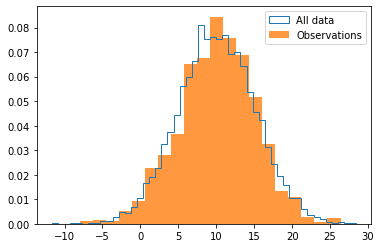

In [2]:
mu_true = 10
sigma_true = 5
data = np.random.normal(mu_true, sigma_true, 10000)
obs = np.random.choice(data, 1000, replace=False)

plt.hist(data, bins=50, label='All data', density=True, alpha=1, histtype='step')
plt.hist(obs, bins=20, label='Observations', density=True, alpha=0.8, histtype='stepfilled')
plt.legend()
plt.show()

<!--start-block-->
<hr style="height: 1px;">

## 13.3 Exercise 1


Now we will implement some of the moving parts of Metropolis-Hastings to sample from the posterior of the mean only. (You can do both mu and sigma later).

1) First implement a likelihood function which takes in the parameter vector (this is just mu for now)
and returns the likelihood of the observed data under those parameter values.

2) Implement a proposal distribution/ transition model.

3) Implement a prior for the parameters.

Note: You should work in log space as much as possible for numerical stability. If you see NaNs, you are probably multiplying very small/large values.
<br>
<!--end-block-->

In [3]:
def likelihood(D, mu, sigma):
    """Returns the likelihood of the data given the parameters

    Args:
        D (array[float]): Array of observed data points.
        mu (float): Mean of the distribution.
        sigma (float): Standard deviation of the distribution.

    Returns:
        float: likelihood of the data given the parameters.
    """    
    log_likelihood = stats.norm.logpdf(D, mu, sigma).sum()
    # Implement a likelihood function for the model used to generate the data
    # make sure to avoid multiplying very small numbers to avoid underflow
    return log_likelihood# return a single value for the likelihood/loglikelihood for the entire dataset: p(x|D)
# you can also use stats.norm from scipy 
# which implements methods for all sorts of useful things like the pdf and cdf


def transition_model(x):
    """Returns the next state of the Markov chain given the current state x.

    Args:
        x (float or array[float]): Current state of the Markov chain. 

    Returns:
        float or array[float]: Next state of the Markov chain.
    """    
    new_x = np.random.normal(x, .1)
    # Implement a symmetric transition model
    # Remember if the transition density is not symmetric, 
    # you will need to account for this term in the acceptance probability

    # For now we will run the MCMC over the mean only and assume we know the true sigma
    # An easy transition_model is to sample from a normal distribution around the current mean
    return new_x

def prior(x):
    """Returns the prior probability of the current state x. 

    Args:
        x (float or array[float]): Current state of the Markov chain. 

    Returns:
        float: p(x)
    """    
    log_prior = stats.norm.logpdf(x, 11, 5)
    # Implement a prior for mu you can pick a uniform prior or something else
    return log_prior# return a single value for the prior

Now let's combine these pieces to implement the metropolis-hastings algorithm (see above for details). 

In [4]:
def step(mu, sigma):
    # A single step of the Markov chain
    # This function should return the new value of mu and sigma
    # and the loglikelihood of the new value
    # You will change this later to step over sigma as well
    return transition_model(mu), sigma, likelihood(obs, mu, sigma)

def metro_hastings(mu, sigma, n_samples=1000):
    # Implement the Metropolis-Hastings algorithm
    samples = []
    while i< n_samples:
        new_mu, sigma, log_likelihood, log_prior = step(data, mu, 5)
        log_ratio = prior(new_mu) + likelihood(data, new_mu, sigma) - (log_likelihood
    
    return # samples

In [ ]:
# Run your Metropolis-Hastings algorithm
# to generate 1000 samples
samples, sample_index, all_mus= metro_hastings(0, 5, n_samples=1000)
print("acceptancerate:", len(samples)/len(all_mus))
# What is your acceptance rate?
# What determines this value? How can you make it larger?
# Hint: try changing your jumping distribution
plt.scatter(sample_index, samples, alpha =.5, s=10)
plt.show()

# Make some plots to visualize your markov chain with (parameter as a function of step for example)
# both accepted and rejected proposals
# What happens in the early steps?
# This is why there is a "burn-in" phase in MCMC methods.

In many cases we want to generate independent identically distributed samples.
Let's check if that's what we got.

The function plt.accor plots the correlation between samples at different distances $\tau$,
 $$C(\tau) = Corr(x_t,x_{t-\tau})$$
 at $\tau = 0$, $C(0)$ is always 1 since it's the correlation of a random variable with itself.

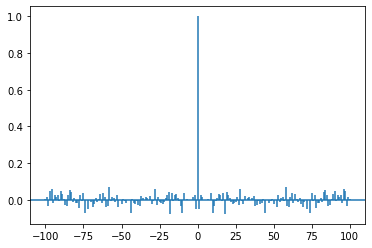

In [3]:
# Use plt.acorr to plot the autocorrelation of the samples you generated 
# (make sure to remove the mean first i.e. samples - np.mean(samples))
# and compare that to a true i.i.d sample from a normal distribution (np.random.randn)
# Do you notice a problem?
# Try the same thing with every 10th sample for example. You should notice less autocorrelation.
# This is why people use "thinning" in MCMC methods.
# Another way to fix this is to use a proposal distribution with larger step sizes.

plt.acorr(np.random.randn(1000), maxlags=100)
plt.show()

<!--start-block-->
<hr style="height: 1px;">

## 13.3 Exercise 2


Now we will do some parameter estimation!
Hints:
The mean of the sample can be a good estimator.
A 95% credible interval (CI) is an interval which contains
the true value of the parameter $\theta$ with probability 0.95. 
You can find a few examples of ways to construct a CI here
https://en.wikipedia.org/wiki/Credible_interval
<br>
<!--end-block-->

Construct a 90% Credible Interval for the true mean using
the samples you generated from MCMC. You can use the function np.percentile from numpy
to compute the percentiles of the samples.


In [4]:
# Make a histogram of your samples (don't forget about burn-in)
# Plot your best estimate of the true mean
# along with the edges of your credible interval.
# Are the results reasonable?
# How can you have a "better" interval?
# Hint: Investigate how the number of observations affects
# your results.

plt.hist(samples[100::], bins=50, density=True, alpha=.5)
plt.axvline(mu_true, color='r', linestyle='--', label='Estimated Mean')
CI = np.percentile(samples[100::], [2.5, 97.5])
plt.axcline(CI[0], color='g', linestyle='--', label = '95% CI')
plt.axcline(CI[1], color='g', linestyle='--')
plt.legend()
plt.show()

NameError: name 'samples' is not defined

In [ ]:
# Optional: 
# Run the MCMC algorithm for both mu and sigma 
# and plot the mean and the 90% CI

# How can you make the MCMC algorithm more efficient?
# How can you make the samples independent?
# The answer can be found here: https://arxiv.org/pdf/2101.08176.pdf
# The key idea is that you can use "Normalizing Flows" to approximate
# the target distribution which you can then correct using Metropolis-Hastings
# to obtain an exact i.i.d sample of the target distribution. 